### This Jupyter Notebook contains all code necessary to recreate the project for HID331 - Big Data Applications in Predicting Hospital Readmissions

### Cells should be execute in descending order

## Import libraries and set notebooks settings

In [34]:
#  Import key libraries and set custom Jupyter Notebook setting for displaying Pandas DataFrames
import pandas as pd
pd.set_option('display.max_columns', None) # Forces notebook to display all columns of DataFrames

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score, roc_curve
from sklearn.feature_selection import RFE, RFECV

from statsmodels.stats.outliers_influence import variance_inflation_factor

import itertools
from itertools import compress

## Import DataFrame, complete pre-processing and data clean-up 

In [35]:
## Load and clean up data

#Load main DataFrame from CSV in github repository
df = pd.read_csv('https://raw.githubusercontent.com/bigdata-i523/hid331/master/project/diabetic_data.csv'
                 ,sep = ','
                 ,na_values = '?')

"""
Create subset of dataframe keeping the first encounter provided for each 'patient_nbr' value. This keeps the rows with
the lowest index value and the lowest encounter ID value. This is build on the assumption that encounter IDs are assigned
sequentially as admissions occur

Also excluding encounters with a discharge type that suggests a readmission is planned, unlikely or impossible

Keeping only one admission per patient is important for ensuring the observations are independent 
"""
df = df[~df['discharge_disposition_id'].isin([11,12,13,14,19,20,21])].sort_index(ascending = True).drop_duplicates(subset = ['patient_nbr'], keep = 'first')

# Load lookup tables
admitTypeDf = pd.read_excel('DiabeticDataMap.xlsx'
                ,sheet_name = 'admitType')
dischargeDispDf = pd.read_excel('DiabeticDataMap.xlsx'
                ,sheet_name = 'dischargeDisp')
admitSourceDf = pd.read_excel('DiabeticDataMap.xlsx'
                ,sheet_name = 'admitSource')

# Merge admit source id description, drop id column
df = df.merge(admitSourceDf
                ,how ='inner'
                ,on = 'admission_source_id')
df.rename(columns = {'description' : 'admission_source'}
                ,inplace = True)
del df['admission_source_id']

# Merge admit type id description, drop id column
df = df.merge(admitTypeDf
               ,how ='inner'
               ,on = 'admission_type_id')
df.rename(columns = {'description' : 'admission_type'}
               ,inplace = True)
del df['admission_type_id']

# Merge discharge disposition id description, drop id column
df = df.merge(dischargeDispDf
               ,how ='inner'
               ,on = 'discharge_disposition_id')
df.rename(columns = {'description' : 'discharge_disposition'}
               ,inplace = True)
del df['discharge_disposition_id']

# Delete weight column as it is mostly null
del df['weight']

# Trim diagnosis codes by trimming decimal and characters right of the decimal
for col in ['diag_1','diag_2','diag_3']:
    df[col] = df[col].str.split('.').str[0]

# Define ICD9 diagnosis code categories
icd9Cats = ['Infectious and Parasitic Diseases'
            ,'Neoplasms'
            ,'Endocrine, Nutritional, Metabolic, Immunity'
            ,'Blood and Blood-Forming Organs'
            ,'Mental Disorders'
            ,'Nervous System and Sense Organs'
            ,'Circulatory System'
            ,'Respiratory System'
            ,'Digestive System'
            ,'Genitourinary System'
            ,'Pregnancy, Childbirth, and the Puerperium'
            ,'Skin and Subcutaneous Tissue'
            ,'Musculoskeletal System and Connective Tissue'
            ,'Congenital Anomalies'
            ,'Conditions Originating in the Perinatal Period'
            ,'Symptoms'
            ,'Nonspecific Abnormal Findings'
            ,'Ill-defined and Unknown Causes of Morbidity and Mortality'
            ,'Injury and Poisoning']

# Fill ICD9 diagnosis code category columns with 0's
for col in icd9Cats:
    df[col] = 0

# ICD9 diagnosis code groups
infDx = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23'
         ,'24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39','40','41','42','43','44'
         ,'45','46','47','48','49','50','51','52','53','54','55','56','57','58','59','60','61','62','63','64','65'
         ,'66','67','68','69','70','71','72','73','74','75','76','77','78','79','80','81','82','83','84','85','86'
         ,'87','88','89','90','91','92','93','94','95','96','97','98','99','100','101','102','103','104','105','106'
         ,'107','108','109','110','111','112','113','114','115','116','117','118','119','120','121','122','123','124'
         ,'125','126','127','128','129','130','131','132','133','134','135','136','137','138','139']

neoDx = ['140','141','142','143','144','145','146','147','148','149','150','151','152','153','154','155','156','157'
         ,'158','159','160','161','162','163','164','165','166','167','168','169','170','171','172','173','174','175'
         ,'176','177','178','179','180','181','182','183','184','185','186','187','188','189','190','191','192','193'
         ,'194','195','196','197','198','199','200','201','202','203','204','205','206','207','208','209','210','211'
         ,'212','213','214','215','216','217','218','219','220','221','222','223','224','225','226','227','228','229'
         ,'230','231','232','233','234','235','236','237','238','239']

endoDx = ['240','241','242','243','244','245','246','247','248','249','250','251','252','253','254','255','256','257'
          ,'258','259','260','261','262','263','264','265','266','267','268','269','270','271','272','273','274','275'
          ,'276','277','278','279']

bloodDx = ['280','281','282','283','284','285','286','287','288','289']

mentalDx = ['290','291','292','293','294','295','296','297','298','299','300','301','302','303','304','305','306','307'
            ,'308','309','310','311','312''313','314','315','316','317','318','319']

nervDx = ['320','321','322','323','324','325','326','327','328','329','330','331','332','333','334','335','336','337'
          ,'338','339','340','341','342','343','344','345','346','347','348','349','350','351','352','353','354','355'
          ,'356','357','358','359','360','361','362','363','364','365','366','367','368','369','370','371','372','373'
          ,'374','375','376','377','378','379','380','381','382','383','384','385','386','387','388','389']

circDx = ['390','391','392','393','394','395','396','397','398','399','400','401','402','403','404','405','406','407'
          ,'408','409','410','411','412','413','414','415','416','417','418','419','420','421','422','423','424','425'
          ,'426','427','428','429','430','431','432','433','434','435','436','437','438','439','440','441','442','443'
          ,'444','445','446','447','448','449','450','451','452','453','454','455','456','457','458','459']

respDx = ['460','461','462','463','464','465','466','467','468','469','470','471','472','473','474','475','476','477'
          ,'478','479','480','481','482','483','484','485','486','487','488','489','490','491','492','493','494','495'
          ,'496','497','498','499','500','501','502','503','504','505','506','507','508','509','510','511','512','513'
          ,'514','515','516','517','518','519']

digeDx = ['520','521','522','523','524','525','526','527','528','529','530','531','532','533','534','535','536','537'
          ,'538','539','540','541','542','543','544','545','546','547','548','549','550','551','552','553','554','555'
          ,'556','557','558','559','560','561','562','563','564','565','566','567','568','569','570','571','572','573'
          ,'574','575','576','577','578','579']

geniDx = ['580','581','582','583','584','585','586','587','588','589','590','591','592','593','594','595','596','597'
          ,'598','599','600','601','602','603','604','605','606','607','608','609','610','611','612','613','614','615'
          ,'616','617','618','619','620','621','622','623','624','625','626','627','628','629']

pregDx = ['630','631','632','633','634','635','636','637','638','639','640','641','642','643','644','645','646','647'
          ,'648','649','650','651','652','653','654','655','656','657','658','659','660','661','662','663','664','665'
          ,'666','667','668','669','670','671','672','673','674','675','676','677','678','679']

skinDx = ['680','681','682','683','684','685','686','687','688','689','690','691','692','693','694','695','696','697'
          ,'698','699','700','701','702','703','704','705','706','707','708','709']

muscDx = ['710','711','712','713','714','715','716','717','718','719','720','721','722','723','724','725','726','727'
          ,'728','729','730','731','732','733','734','735','736','737','738','739']

congDx = ['740','741','742','743','744','745','746','747','748','749','750','751','752','753','754','755','756','757'
          ,'758','759']

periDx = ['760','761','762','763','764'
          ,'765','766','767','768','769','770','771','772','773','774','775','776','777'
          ,'778','779']
symDx = ['780','781','782','783','784','785','786','787','788','789']

nonspecDx = ['790','791','792','793','794','795','796']

illDx = ['797','798','799']

injDx = ['800','801','802','803','804','805','806','807','808','809','810','811','812','813','814','815','816','817'
         ,'818','819','820','821','822','823','824','825','826','827','828','829','830','831','832','833','834','835'
         ,'836','837','838','839','840','841','842','843','844','845','846','847','848','849','850','851','852','853'
         ,'854','855','856','857','858','859','860','861','862','863','864','865','866','867','868','869','870','871'
         ,'872','873','874','875','876','877','878','879','880','881','882','883','884','885','886','887','888','889'
         ,'890','891','892','893','894','895','896','897','898','899','900','901','902','903','904','905','906','907'
         ,'908','909','910','911','912','913','914','915','916','917','918','919','920','921','922','923','924','925'
         ,'926','927','928','929','930','931','932','933','934','935','936','937','938','939','940','941','942','943'
         ,'944','945','946','947','948','949','950','951','952','953','954','955','956','957','958','959','960','961'
         ,'962','963','964','965','966','967','968','969','970','971','972','973','974','975','976','977','978','979'
         ,'980','981','982','983','984','985','986','987','988','989','990','991','992','993','994','995','996','997'
         ,'998','999']  

icd9Grps = [infDx,neoDx,endoDx,bloodDx,mentalDx,nervDx,circDx,respDx,digeDx,geniDx,pregDx,skinDx,muscDx,congDx,periDx
            ,symDx,nonspecDx,illDx,injDx]

# Iterate through diagnosis code columns, update ICD9 diagnosis code category columns if it contains a code from the
# corresponding ICD9 diagnosis code group
for col in ['diag_1','diag_2','diag_3']:
    for dxCat, dxGrp in zip(icd9Cats, icd9Grps):
        df.loc[df[col].isin(dxGrp), dxCat] = 1

# Add additional diagnosis code column for E codes
df['External Causes of Injury'] = 0

# Iterate through diagnosis code columns, update E code column if patient encounter had an E code
for col in ['diag_1','diag_2','diag_3']:
    df.loc[df[col].str.startswith('E', na = False), 'External Causes of Injury'] = 1
    
# Drop diagnosis code columns
del df['diag_1']
del df['diag_2']
del df['diag_3']

# Drop medical specialty column
del df['medical_specialty']

# Fill nulls with 'Not Available'
nullCols = ['payer_code','admission_source','admission_type','discharge_disposition','race']
for col in nullCols:
    df[col] = df[col].fillna('Not Available')

# Fix 'Not Available' that has leading space
df.loc[df['admission_source'] == ' Not Available','admission_source'] ='Not Available'

# Identify category columns do be encoded by get_dummies. note #excluding columns 'diag1','diag2','diag3','payer_code','medical_specialty'
categoryCols = ['race','gender','age','payer_code','max_glu_serum','A1Cresult','metformin','repaglinide','nateglinide'
                ,'chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone'
                ,'rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton','insulin'
                ,'glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone'
                ,'metformin-pioglitazone', 'change', 'diabetesMed','admission_source','admission_type'
                ,'discharge_disposition']

df = pd.get_dummies(df
                    ,columns = categoryCols
                    ,drop_first = False)

# Drop Unknown, not mapped columns
unkCols = ['race_Not Available','race_Other','gender_Unknown/Invalid','payer_code_Not Available','admission_source_Not Available',
'admission_source_ Not Mapped','admission_type_Not Mapped','admission_type_Not Available','discharge_disposition_Not Available'
,'discharge_disposition_Not Mapped']
for col in unkCols:
    del df[col]

# Drop columns that are 0 throughout
for col in df.columns.values:
    if df[col].sum() == 0:
        del df[col]

# Drop columns that are 1 throughout
for col in df.columns.values:
    if df[col].sum() == df.shape[0]:
        del df[col]
    
# Overwrite labels that read '>30' to say 'NO' because these patients were not readmitted within 30 days
df.loc[df['readmitted'] == '>30', 'readmitted'] = 'NO'

#Convert readmission response labels to 0's and 1's
df.loc[df['readmitted'] == 'NO', 'readmitted'] = '0'
df.loc[df['readmitted'] == '<30', 'readmitted'] = '1'
df['readmitted'] = df['readmitted'].astype(int)

# Separate features from response
X_orig = df.drop(['encounter_id', 'patient_nbr','readmitted'], axis = 1)
X = X_orig.copy()
y = df['readmitted']

/home/petersontylerd/.pyenv/versions/3.6.2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


##  Custom functions

In [36]:
# Function for cleaning up features with high VIF values
def vifCollinearTrim(X, threshold = 5.0):
    """
    This function trims columns with high VIF. A column with a high VIF is a column that well explained by the 
    other columns in the independent variable set.

    The function loops through each set of dummy columns. If there is a column in that set with a VIF
    higher than the threshold, and the set has more than one column remaining, the column with the high VIF 
    will be dropped from the current column list.

    After trimming down the dummy column groups such that all values within each group are below the threshold
    or the number of columns in the group is one, the scope of the loop will expand from subsets of dummy 
    columns to the whole set of remaining columns to trim additional collinearity that exists between 
    categories.
    """
    vif = [threshold] # Ensure the while loop initiates
    startingCols = X.columns.values # Array of all column names
    
    # Identify all single columns and all dummy features that stemmed from categorical columns
    dummyCols = []
    singleCols = []
    for i in categoryCols:
        dummyCols.append([col for col in startingCols if col.startswith(i + '_')])
    dummyCols = list(itertools.chain.from_iterable(dummyCols)) # Flatten list of lists into one list
    for i in startingCols:
        if i not in dummyCols:
            singleCols.append(i)
    
    #While the maximum value in the VIF list is higher than the threshold...
    passCount = 0
    
    corr = np.corrcoef(X, rowvar = 0)
    print('Initial determinant for X: {0}'.format(np.linalg.det(corr)))
    print('Initial condition number for X: {0}'.format(np.linalg.cond(corr)))
    print()
    while max(vif) >= threshold:
        passCount += 1
        indVarCols = X.columns.values # Get array of current independent variable column names
        vif = [variance_inflation_factor(X[indVarCols].values, i) for i in range(len(indVarCols))] # Get VIF
        print('Columns remaing: {}'.format(len(indVarCols)))
        print('Column/VIF pairs for pass #{0}:'.format(passCount))
        for i,j in zip(indVarCols, vif):
            print(i, j)
        print() #Report Spacer
        
        if max(vif) >= threshold:
            # Iterate through categoryCols, build list of all dummy columns that stemmed from categoryCol
            for i in categoryCols:
                colSet = [col for col in indVarCols if col.startswith(i + '_')]
                
                # If the categoryCol has more than one column remaining in the DataFrame
                if len(colSet) > 1:
                    # Get the indexes of the colSet columns from the indValCols array
                    colSetIx = []
                    for i in colSet:
                        colSetIx.append(np.where(indVarCols == i)[0][0])
                    
                    # Get the corresponding VIF value for each of the colSet columns by using indValCols index
                    # If the maximum VIF in colSetVals is higher than the threshold value
                    colSetVif = [vif[i] for i in colSetIx]
                    if max(colSetVif) > threshold:
                        maxValIx = colSetVif.index(max(colSetVif))# Get the index for the max value from colSetVif
                        maxValCol = colSet[maxValIx] # Use the index for the max value from colSetVif to get the corresponding column name from colSet
                        del X[maxValCol] # Delete the column with that name
                        print('During pass #{0}, test 1 dropped column: {1}. VIF was {2}'.format(passCount, maxValCol, max(colSetVif)))
                        print()
                
                # For dummy variable lists that only have 1 column
                if len(colSet) == 1:
                    for i in colSet:
                        ix = np.where(indVarCols == i)[0][0]
                        if vif[ix] >= threshold:
                            del X[i] # Delete the column with that name
                            print('During pass #{0}, test 2 dropped column: {1}. VIF was {2}'.format(passCount, i, vif[ix]))
                            print()
            
            # Iterate through singlCols
            for i in singleCols:
                ix = np.where(indVarCols == i)[0][0]
                if vif[ix] >= threshold:
                    del X[i] # Delete the column with that name
                    singleCols.remove(i)
                    print('During pass #{0}, test 3 dropped column: {1}. VIF was {2}'.format(passCount, i, vif[ix]))
                    print()

        # Trim status report
        print('{0} columns remaining after pass #{1}: {2}'.format(len(X.columns.values), passCount, X.columns.values))
        print() #Report Spacer
        corr = np.corrcoef(X, rowvar = 0)
        print('Determinant for X after pass #{0}: {1}'.format(passCount, np.linalg.det(corr)))
        print('Condition number for X after pass #{0}: {1}'.format(passCount, np.linalg.cond(corr)))
        print('----------------------------------------------------------------------') #Report Spacer
        print() #Report Spacer
    
    # Final status report
    print('{0} columns remaining after pass #{1}: {2}'.format(len(X.columns.values), passCount, X.columns.values))
    print() #Report Spacer
    corr = np.corrcoef(X, rowvar = 0)
    print('Determinant for X after pass #{0}: {1}'.format(passCount, np.linalg.det(corr)))
    print('Condition number for X after pass #{0}: {1}'.format(passCount, np.linalg.cond(corr)))
    
    return X

In [37]:
# Functions for evaluating correlation coefficients and condition of matrices
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

def is_invertible(a):
    return a.shape[0] == a.shape[1] and np.linalg.matrix_rank(a) == a.shape[0]

## Trim features from original feature list based on VIF 

In [4]:
# Executes the function vifCollinearTrim. Important - Do not run this, run the cell below instead.
# This function takes about an hour to run on my machine. The cell below includes the list of the columns 
# that this function decides to keep. By running the following cell, the main indepedent variable 
# DataFrame X gets overwritten to only include the columns selected by this function.
#
# The output of this cell includes the report generated by the function for reference. One could review the 
# output to observe how the dataset is trimmed by each pass and how the condition of the matrix improves
# with each pass.
X = vifCollinearTrim(X = X, threshold = 5.0)

Initial determinant for X: 0.0
Initial condition number for X: 2.915382899925452e+20



/home/petersontylerd/.pyenv/versions/3.6.2/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Columns remaing: 174
Column/VIF pairs for pass #1:
time_in_hospital 1.6222591443
num_lab_procedures 1.4732257368
num_procedures 1.43643315496
num_medications 1.92336889369
number_outpatient 1.05411822722
number_emergency 1.05401398218
number_inpatient 1.07073452088
number_diagnoses 1.4497399056
Infectious and Parasitic Diseases 1.11266470313
Neoplasms 1.15153897885
Endocrine, Nutritional, Metabolic, Immunity 1.44531046564
Blood and Blood-Forming Organs 1.0939570056
Mental Disorders 1.17315049124
Nervous System and Sense Organs 1.05979254379
Circulatory System 1.79237085703
Respiratory System 1.30703163971
Digestive System 1.2463061092
Genitourinary System 1.22194543211
Pregnancy, Childbirth, and the Puerperium 1.26712492965
Skin and Subcutaneous Tissue 1.15004241068
Musculoskeletal System and Connective Tissue 1.23441973481
Congenital Anomalies 1.00562867444
Symptoms 1.17471027534
Nonspecific Abnormal Findings 1.01176177248
Ill-defined and Unknown Causes of Morbidity and Mortality 1.01

Columns remaing: 145
Column/VIF pairs for pass #2:
time_in_hospital 5.01107764968
num_lab_procedures 8.20417797221
num_procedures 2.36921827264
num_medications 8.73377901686
number_outpatient 1.12487508407
number_emergency 1.096876301
number_inpatient 1.15529939398
number_diagnoses 20.1866372739
Infectious and Parasitic Diseases 1.18014081646
Neoplasms 1.22378996513
Endocrine, Nutritional, Metabolic, Immunity 2.93032038569
Blood and Blood-Forming Organs 1.16606509906
Mental Disorders 1.25424547948
Nervous System and Sense Organs 1.10435931899
Circulatory System 4.23126168967
Respiratory System 1.63934960827
Digestive System 1.43631155594
Genitourinary System 1.44452569443
Pregnancy, Childbirth, and the Puerperium 1.27767928912
Skin and Subcutaneous Tissue 1.23210989782
Musculoskeletal System and Connective Tissue 1.34405589751
Congenital Anomalies 1.00836699847
Symptoms 1.36743280295
Nonspecific Abnormal Findings 1.02033311631
Ill-defined and Unknown Causes of Morbidity and Mortality 1

Columns remaing: 124
Column/VIF pairs for pass #3:
num_lab_procedures 5.7310059255
num_procedures 2.00925927312
number_outpatient 1.11749327426
number_emergency 1.09377059179
number_inpatient 1.14747205198
Infectious and Parasitic Diseases 1.13543638649
Neoplasms 1.15106909522
Endocrine, Nutritional, Metabolic, Immunity 2.14718746938
Blood and Blood-Forming Organs 1.125602476
Mental Disorders 1.18259125724
Nervous System and Sense Organs 1.07187655802
Circulatory System 2.81840636975
Respiratory System 1.39860227201
Digestive System 1.27158480428
Genitourinary System 1.31329508639
Pregnancy, Childbirth, and the Puerperium 1.25369724852
Skin and Subcutaneous Tissue 1.16761796891
Musculoskeletal System and Connective Tissue 1.25051842943
Congenital Anomalies 1.00660851218
Symptoms 1.21543676513
Nonspecific Abnormal Findings 1.01367820733
Ill-defined and Unknown Causes of Morbidity and Mortality 1.02087320954
Injury and Poisoning 1.31287145861
External Causes of Injury 1.13738360333
race_

Columns remaing: 123
Column/VIF pairs for pass #4:
num_procedures 1.932320555
number_outpatient 1.11728784792
number_emergency 1.09375580812
number_inpatient 1.1363619491
Infectious and Parasitic Diseases 1.10998928515
Neoplasms 1.13404534638
Endocrine, Nutritional, Metabolic, Immunity 2.03447185028
Blood and Blood-Forming Organs 1.11352446131
Mental Disorders 1.16550125063
Nervous System and Sense Organs 1.06502703729
Circulatory System 2.52205948438
Respiratory System 1.30978146074
Digestive System 1.21558723722
Genitourinary System 1.23411743773
Pregnancy, Childbirth, and the Puerperium 1.25113655518
Skin and Subcutaneous Tissue 1.15771718397
Musculoskeletal System and Connective Tissue 1.24728321155
Congenital Anomalies 1.0064115406
Symptoms 1.18884808141
Nonspecific Abnormal Findings 1.01191861165
Ill-defined and Unknown Causes of Morbidity and Mortality 1.01814079937
Injury and Poisoning 1.30098268532
External Causes of Injury 1.13307969396
race_AfricanAmerican 1.30773626976
race

Determinant for X after pass #4: 0.00697875196569323
Condition number for X after pass #4: 12.127855040072056


In [38]:
# These are the columns that result from the execution of the function above. Run this cell instead of the
# one above
keptCols = ['num_procedures', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'Infectious and Parasitic Diseases',
       'Neoplasms', 'Endocrine, Nutritional, Metabolic, Immunity',
       'Blood and Blood-Forming Organs', 'Mental Disorders',
       'Nervous System and Sense Organs', 'Circulatory System',
       'Respiratory System', 'Digestive System', 'Genitourinary System',
       'Pregnancy, Childbirth, and the Puerperium',
       'Skin and Subcutaneous Tissue',
       'Musculoskeletal System and Connective Tissue',
       'Congenital Anomalies', 'Symptoms', 'Nonspecific Abnormal Findings',
       'Ill-defined and Unknown Causes of Morbidity and Mortality',
       'Injury and Poisoning', 'External Causes of Injury',
       'race_AfricanAmerican', 'race_Asian', 'race_Hispanic',
       'gender_Male', 'age_[10-20)', 'age_[20-30)', 'age_[30-40)',
       'age_[40-50)', 'age_[50-60)', 'age_[60-70)', 'age_[80-90)',
       'age_[90-100)', 'payer_code_BC', 'payer_code_CH', 'payer_code_CM',
       'payer_code_CP', 'payer_code_DM', 'payer_code_FR', 'payer_code_HM',
       'payer_code_MC', 'payer_code_MD', 'payer_code_MP', 'payer_code_OG',
       'payer_code_OT', 'payer_code_PO', 'payer_code_SI', 'payer_code_SP',
       'payer_code_UN', 'payer_code_WC', 'max_glu_serum_>300',
       'max_glu_serum_Norm', 'A1Cresult_>8', 'A1Cresult_Norm',
       'metformin_Steady', 'metformin_Up', 'repaglinide_Steady',
       'repaglinide_Up', 'nateglinide_Steady', 'nateglinide_Up',
       'chlorpropamide_Steady', 'chlorpropamide_Up', 'glimepiride_Steady',
       'glimepiride_Up', 'acetohexamide_Steady', 'glipizide_Steady',
       'glipizide_Up', 'glyburide_Steady', 'glyburide_Up',
       'tolbutamide_Steady', 'pioglitazone_Steady', 'pioglitazone_Up',
       'rosiglitazone_Steady', 'rosiglitazone_Up', 'acarbose_Steady',
       'acarbose_Up', 'miglitol_Steady', 'miglitol_Up',
       'troglitazone_Steady', 'tolazamide_Steady', 'insulin_Steady',
       'insulin_Up', 'glyburide-metformin_Steady',
       'glyburide-metformin_Up', 'glipizide-metformin_Steady',
       'metformin-rosiglitazone_Steady', 'metformin-pioglitazone_Steady',
       'admission_source_ Court/Law Enforcement',
       'admission_source_ Extramural Birth',
       'admission_source_ Physician Referral',
       'admission_source_ Sick Baby',
       'admission_source_ Transfer from Ambulatory Surgery Center',
       'admission_source_ Transfer from a Skilled Nursing Facility (SNF)',
       'admission_source_ Transfer from another health care facility',
       'admission_source_ Transfer from critial access hospital',
       'admission_source_ Transfer from hospital inpt/same fac reslt in a sep claim',
       'admission_source_Clinic Referral', 'admission_source_HMO Referral',
       'admission_source_Normal Delivery',
       'admission_source_Transfer from a hospital',
       'admission_type_Elective', 'admission_type_Newborn',
       'admission_type_Trauma Center', 'admission_type_Urgent',
       'discharge_disposition_Admitted as an inpatient to this hospital',
       'discharge_disposition_Discharged/transferred to ICF',
       'discharge_disposition_Discharged/transferred to SNF',
       'discharge_disposition_Discharged/transferred to a federal health care facility.',
       'discharge_disposition_Discharged/transferred to a long term care hospital.',
       'discharge_disposition_Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.',
       'discharge_disposition_Discharged/transferred to another rehab fac including rehab units of a hospital .',
       'discharge_disposition_Discharged/transferred to another short term hospital',
       'discharge_disposition_Discharged/transferred to another type of inpatient care institution',
       'discharge_disposition_Discharged/transferred to home under care of Home IV provider',
       'discharge_disposition_Discharged/transferred to home with home health service',
       'discharge_disposition_Discharged/transferred within this institution to Medicare approved swing bed',
       'discharge_disposition_Discharged/transferred/referred another institution for outpatient services',
       'discharge_disposition_Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital',
       'discharge_disposition_Discharged/transferred/referred to this institution for outpatient services',
       'discharge_disposition_Left AMA',
       'discharge_disposition_Neonate discharged to another hospital for neonatal aftercare']
X = X[keptCols]

## Feature selection with Recursive Feature Selection

In [51]:
logreg = LogisticRegression()
rfecv = RFECV(estimator = logreg, cv = 3, scoring = 'accuracy')
rfecv = rfecv.fit(X, y)
print('The optimal number of features is: {}'.format(rfecv.n_features_))
rfeCols = list(compress(X.columns.values, rfecv.support_))
print()
print('The features are: {}'.format(rfeCols))

X = X[rfeCols]

The optimal number of features is: 57


## Create model using logistic regression

In [151]:
# This function models the dataset using logistic regression and reports the training and test set accuracies.
# The funciton also visualizes the coefficient weights. There are parameters that allow the user to 
# loop through varying level of C.
def visLogRegCoef(X, y, CVals, Markers, regType):    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

    for C, marker in zip(CVals, Markers):
        logReg = LogisticRegression(C = C, penalty = regType).fit(X_train, y_train)
        print('Training accuracy of {} logreg with C = {:.3f}: {:.5f}'.format(regType, C, logReg.score(X_train, y_train)))
        print('Test accuracy of {} logreg with C = {:.3f}: {:.5f}'.format(regType, C, logReg.score(X_test, y_test)))
        print()
        
        y_pred = logReg.predict(X_test)
        
        confMat = confusion_matrix(y_test,y_pred)
        print(confMat)
        print()
        
        classRep = classification_report(y_test, y_pred)
        print(classRep)
        print()
        
        plt.plot(logReg.coef_.T, marker, markersize = 15, label = 'C = {:.3f}'.format(C))

    plt.xticks(range(X.shape[1]), rotation = 90)
    plt.hlines(0,0, X.shape[1])
    plt.xlabel('Column Index')
    plt.ylabel('Coefficient Magnitude')
    plt.rcParams['figure.figsize'] = [25,16]
    
    plt.rcParams.update({'font.size': 20})
    
    plt.ylim(-4,4)
    plt.legend(loc = 3)
    plt.savefig('images/weights_{}.png'.format(regType))
    plt.show()


Training accuracy of l2 logreg with C = 0.010: 0.91063
Test accuracy of l2 logreg with C = 0.010: 0.90820

[[12712     3]
 [ 1282     1]]

             precision    recall  f1-score   support

          0       0.91      1.00      0.95     12715
          1       0.25      0.00      0.00      1283

avg / total       0.85      0.91      0.86     13998


Training accuracy of l2 logreg with C = 1.000: 0.91050
Test accuracy of l2 logreg with C = 1.000: 0.90820

[[12709     6]
 [ 1279     4]]

             precision    recall  f1-score   support

          0       0.91      1.00      0.95     12715
          1       0.40      0.00      0.01      1283

avg / total       0.86      0.91      0.87     13998


Training accuracy of l2 logreg with C = 100.000: 0.91050
Test accuracy of l2 logreg with C = 100.000: 0.90820

[[12709     6]
 [ 1279     4]]

             precision    recall  f1-score   support

          0       0.91      1.00      0.95     12715
          1       0.40      0.00      0.

/home/petersontylerd/.pyenv/versions/3.6.2/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


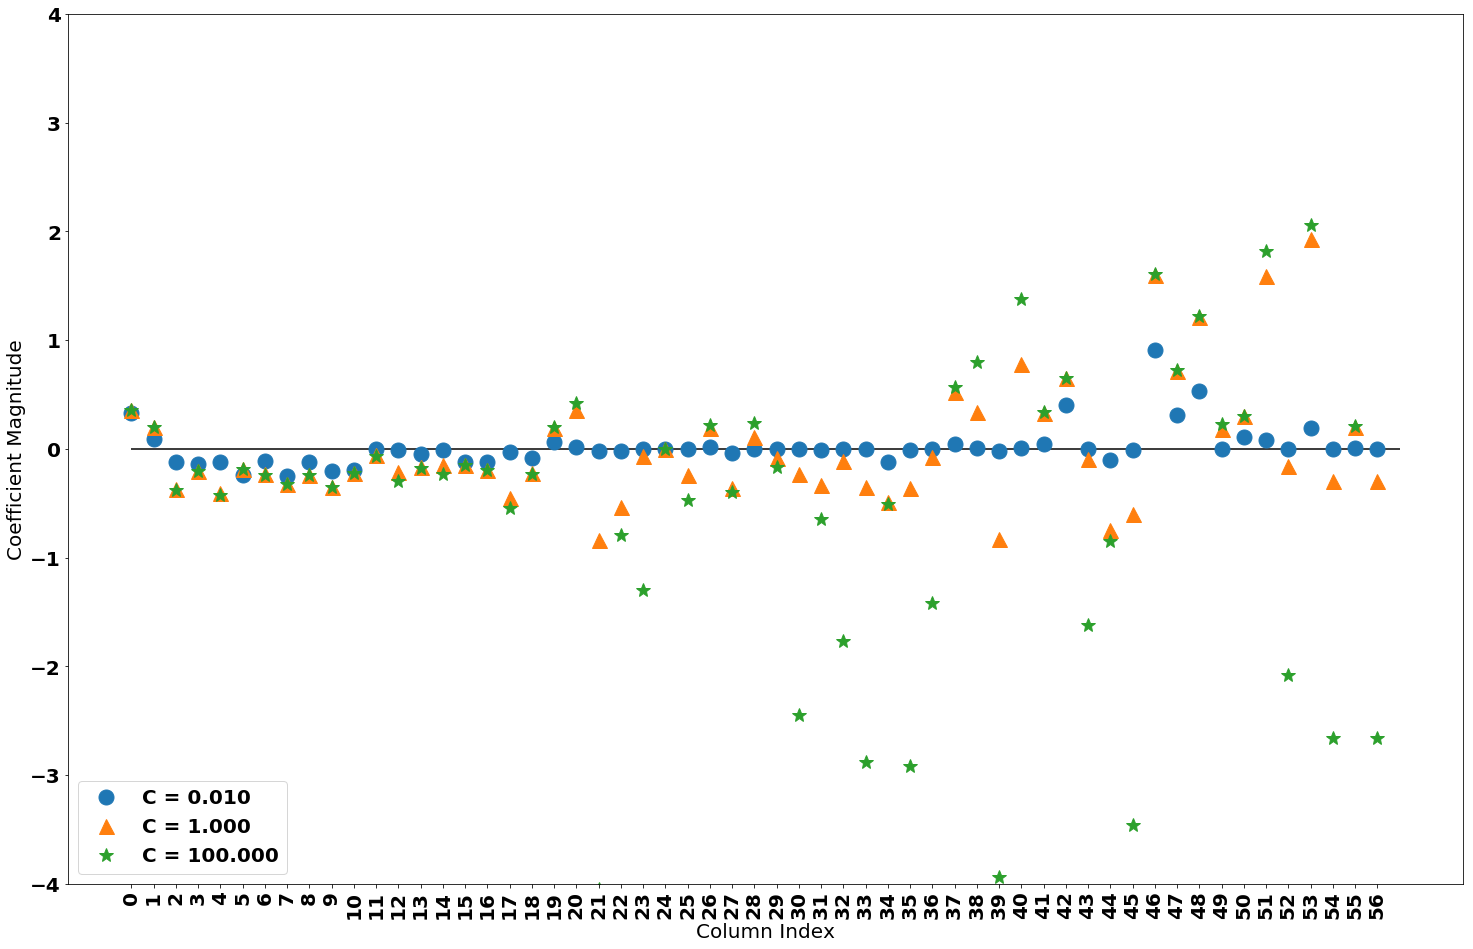

Training accuracy of l1 logreg with C = 0.010: 0.91063
Test accuracy of l1 logreg with C = 0.010: 0.90827

[[12713     2]
 [ 1282     1]]

             precision    recall  f1-score   support

          0       0.91      1.00      0.95     12715
          1       0.33      0.00      0.00      1283

avg / total       0.86      0.91      0.86     13998


Training accuracy of l1 logreg with C = 1.000: 0.91050
Test accuracy of l1 logreg with C = 1.000: 0.90820

[[12709     6]
 [ 1279     4]]

             precision    recall  f1-score   support

          0       0.91      1.00      0.95     12715
          1       0.40      0.00      0.01      1283

avg / total       0.86      0.91      0.87     13998


Training accuracy of l1 logreg with C = 100.000: 0.91050
Test accuracy of l1 logreg with C = 100.000: 0.90820

[[12709     6]
 [ 1279     4]]

             precision    recall  f1-score   support

          0       0.91      1.00      0.95     12715
          1       0.40      0.00      0.

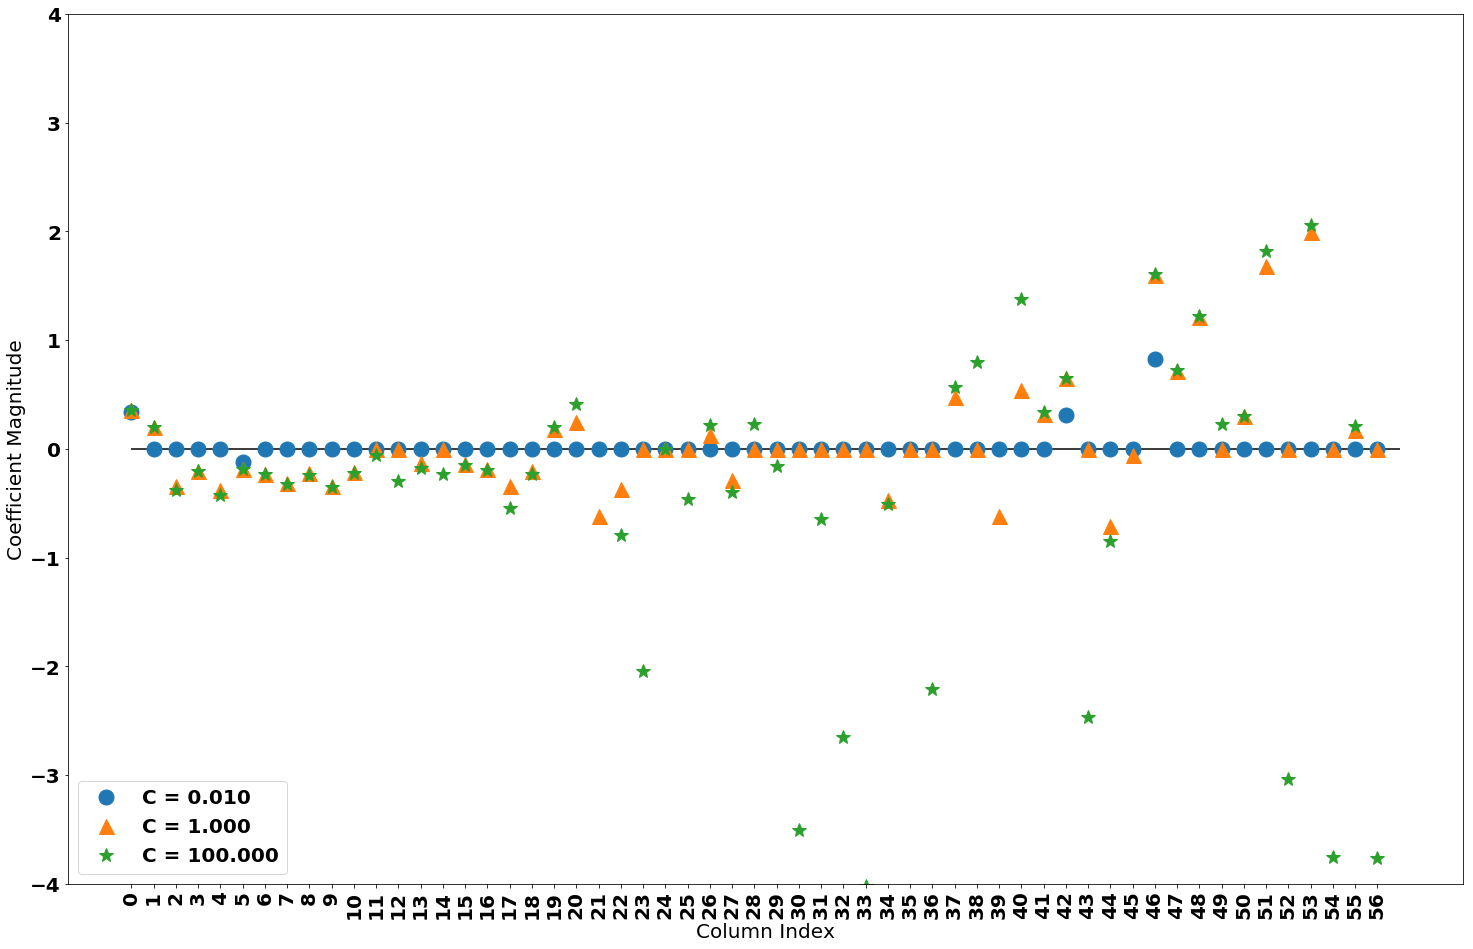

In [152]:
# Execute the function visLogRegCoef using both L1 and L2 regularization and three values for C, 0.01, 1.0 
# and 100.0. The report will display the training accuracy, test accuracy, confusion matrix and classification
# report for each pair of regulatization type and C value.
for regType in ('l2','l1'):
    visLogRegCoef(X = X, y = y, CVals = [0.01, 1.0, 100.0], Markers = ['o','^','*'], regType = regType)

Area under the curve: 0.5003110643463986



/home/petersontylerd/.pyenv/versions/3.6.2/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


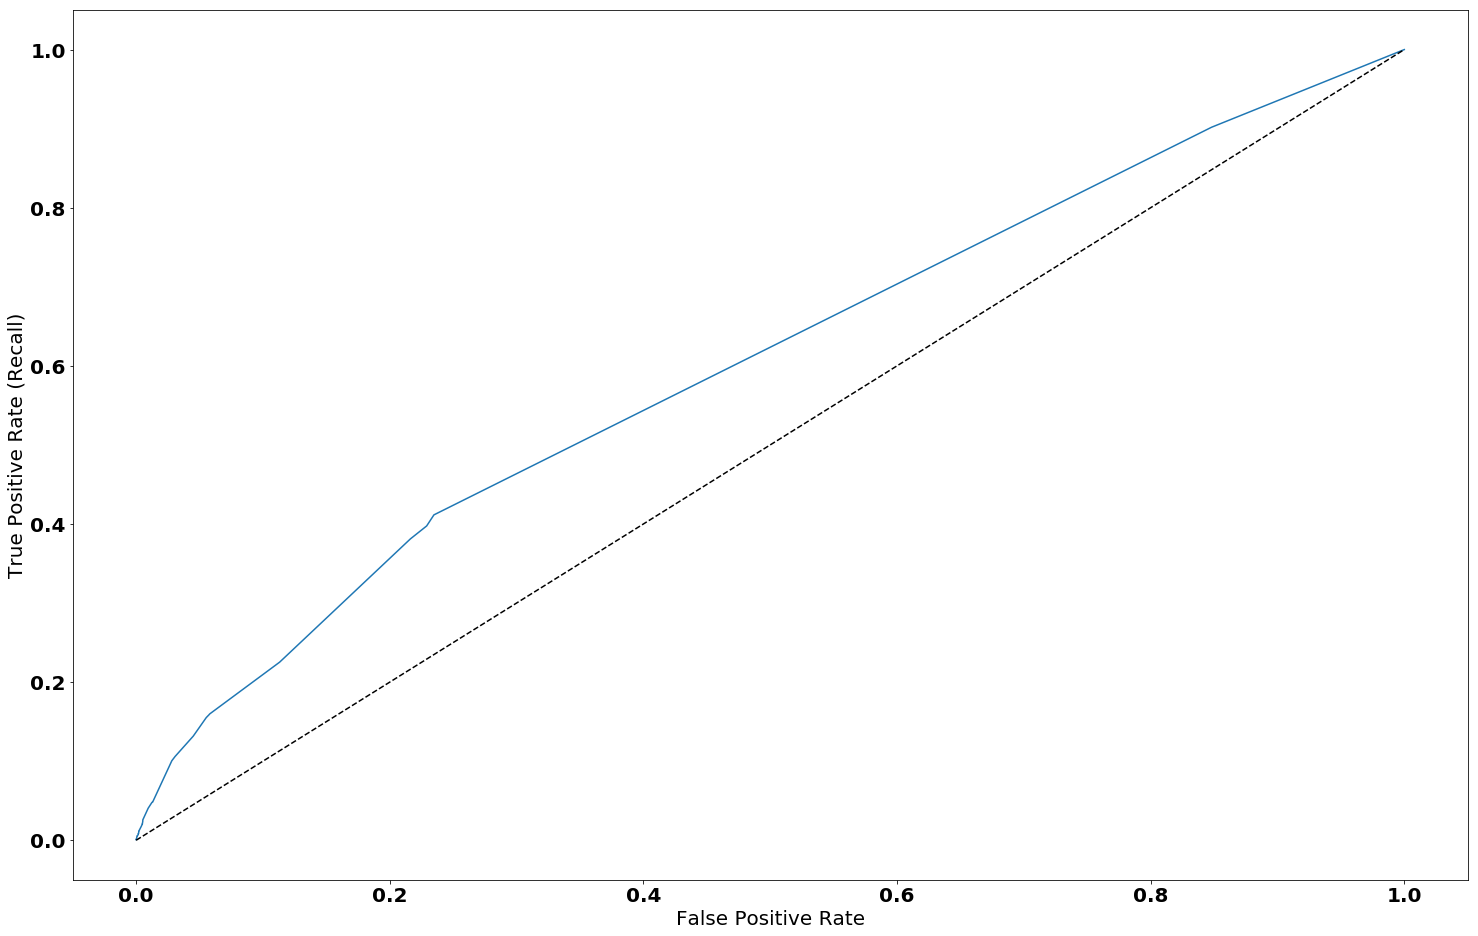

In [179]:
# Create ROC curve for logistic regression model using L1 regularization and C = 0.01
# Calculate the AUC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
logReg = LogisticRegression(C = 0.01, penalty = 'l1').fit(X_train, y_train)       

fpr, tpr, thresholds = roc_curve(y_test, logReg.decision_function(X_test))

print('Area under the curve: {}'.format(roc_auc_score(y_test,logReg.predict(X_test))))
print()

plt.plot(fpr, tpr, label = 'ROC Curve')
plt.plot([0,1],[0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.savefig('images/roc_curve_001.png'.format(regType))
plt.show()

Area under the curve: 0.5013229046526019



/home/petersontylerd/.pyenv/versions/3.6.2/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


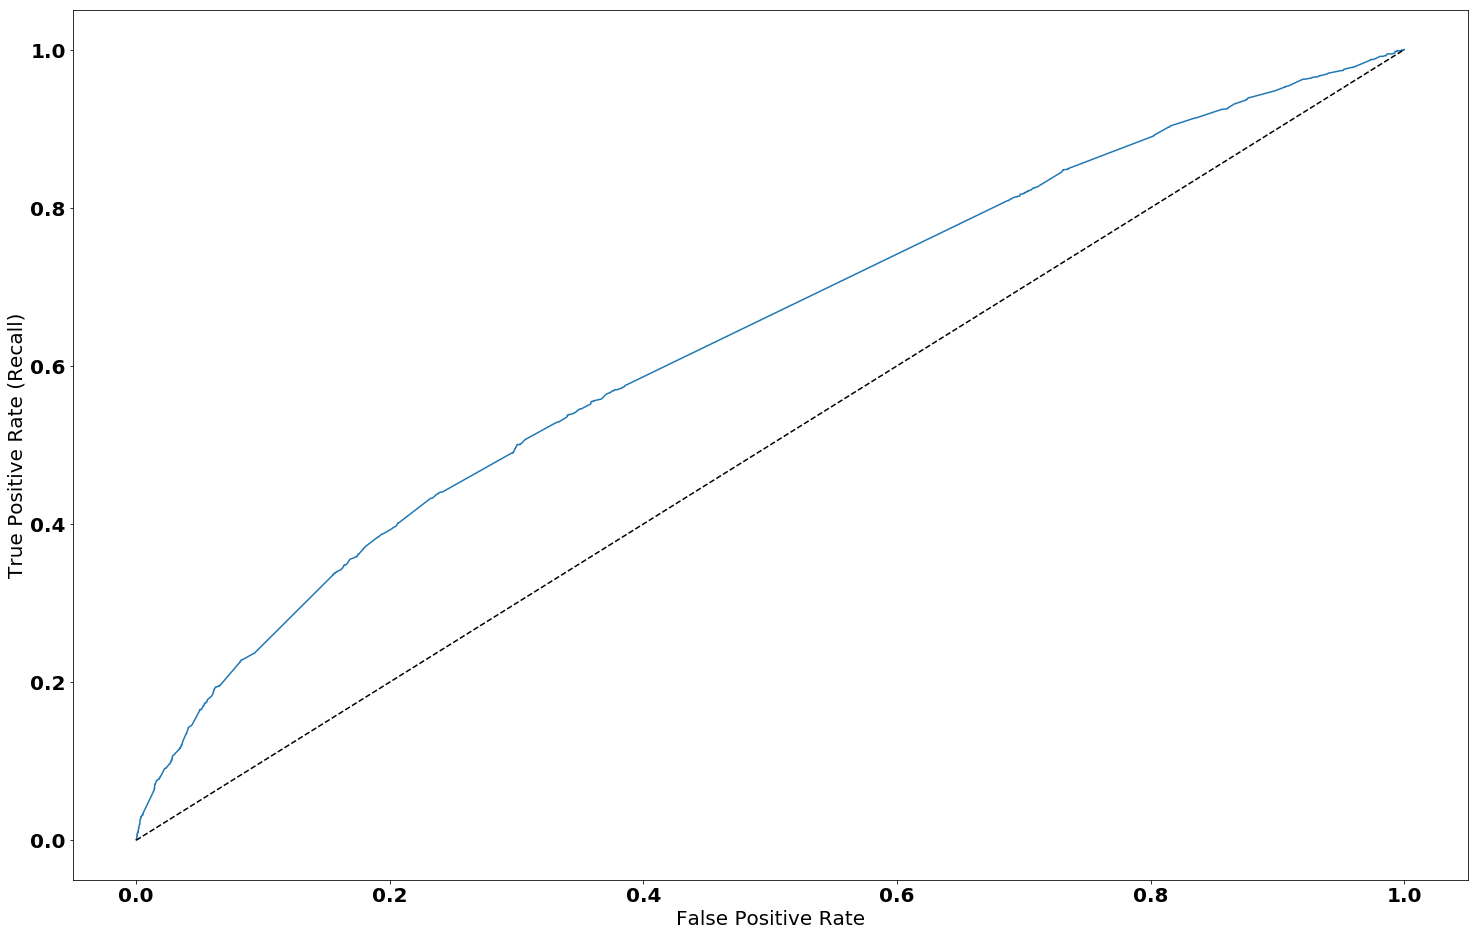

In [180]:
# Create ROC curve for logistic regression model using L1 regularization and C = 100.0
# Calculate the AUC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
logReg = LogisticRegression(C = 100.0, penalty = 'l1').fit(X_train, y_train)       

fpr, tpr, thresholds = roc_curve(y_test, logReg.decision_function(X_test))

print('Area under the curve: {}'.format(roc_auc_score(y_test,logReg.predict(X_test))))
print()

plt.plot(fpr, tpr, label = 'ROC Curve')
plt.plot([0,1],[0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.savefig('images/roc_curve_100.png'.format(regType))
plt.show()

In [ ]:
proofread one more time
go over notebook comments
requirements document
    libraries
    random number seed
fix ciation errors
submit to turnitin
paper 2 review
